In [2]:
#Load packages
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')
import pandas as pd
import pickle
#import networkx as nx
#import matplotlib.pyplot as plt
#import pydot
#from networkx.drawing.nx_pydot import graphviz_layout

#Read in data
books_df = pd.read_csv("../data/Books.csv",)
with open(r"../data/tree-all.pickle", 'rb') as file:
    rawdata = file.read()
books_pickle = pickle.loads(rawdata)

#Function to count the depth of the node
def count_depth (pathName):
   return pathName.count("',")

In [3]:
#This creates the depth column
books_df['Depth'] = books_df.pathName.apply(count_depth)
books_df.head()

,id,name,productCount,subtreeProductCount,parent,numChildren,pathName,children,alsoCount,also,Depth
0,0,Books,1940253,0,0,32,['Books'],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,[],0
1,1,Travel,519,8013,0,17,"['Books', 'Travel']","[3826, 3827, 3828, 3829, 3830, 3831, 3832, 383...",225,"[(1838, 52), (984, 36), (11, 20), (1833, 15), ...",1
2,2,Sports & Outdoors,330,7414,0,24,"['Books', 'Sports & Outdoors']","[3716, 3717, 3718, 3719, 3720, 3721, 3722, 372...",170,"[(3599, 12), (983, 10), (1054, 8), (1701, 8), ...",1
3,3,"Health, Fitness & Dieting",1571,22682,0,17,"['Books', 'Health, Fitness & Dieting']","[3521, 3522, 3523, 3524, 3525, 3526, 3527, 352...",524,"[(11, 520), (27, 83), (706, 60), (2379, 43), (...",1
4,4,Computers & Technology,559,7725,0,18,"['Books', 'Computers & Technology']","[3258, 3259, 3260, 3261, 3262, 3263, 3264, 326...",194,"[(11, 74), (2415, 43), (1014, 17), (2814, 17),...",1


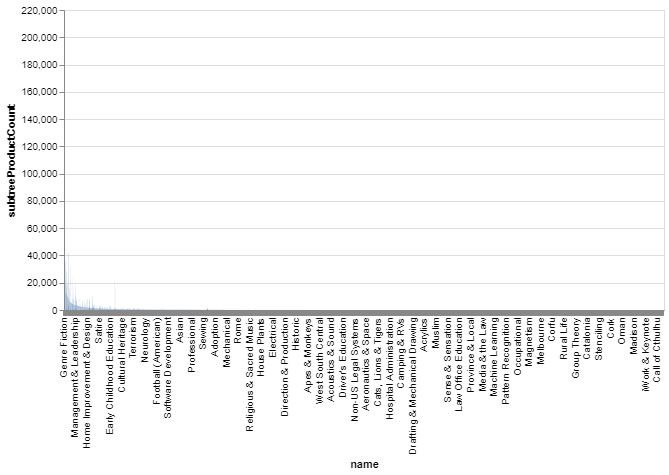

In [50]:
#Add select dropdown for depth
depth_choices = books_df.Depth.unique().tolist()
depth_choices = sorted(depth_choices)
depth_dropdown = alt.binding_select(options=depth_choices)
depth_select = alt.selection_single(fields=['Depth'], bind=depth_dropdown, name = " ")

#Create altair bar chart
alt.Chart(books_df).mark_bar().encode(
    y='subtreeProductCount:Q',
    x=alt.X(
        "name:O",
        sort = alt.SortField(
            field = "subtreeProductCount",
            order = "descending"))
    ).add_selection(depth_select
    ).transform_filter(depth_select
    ).properties(width=600)


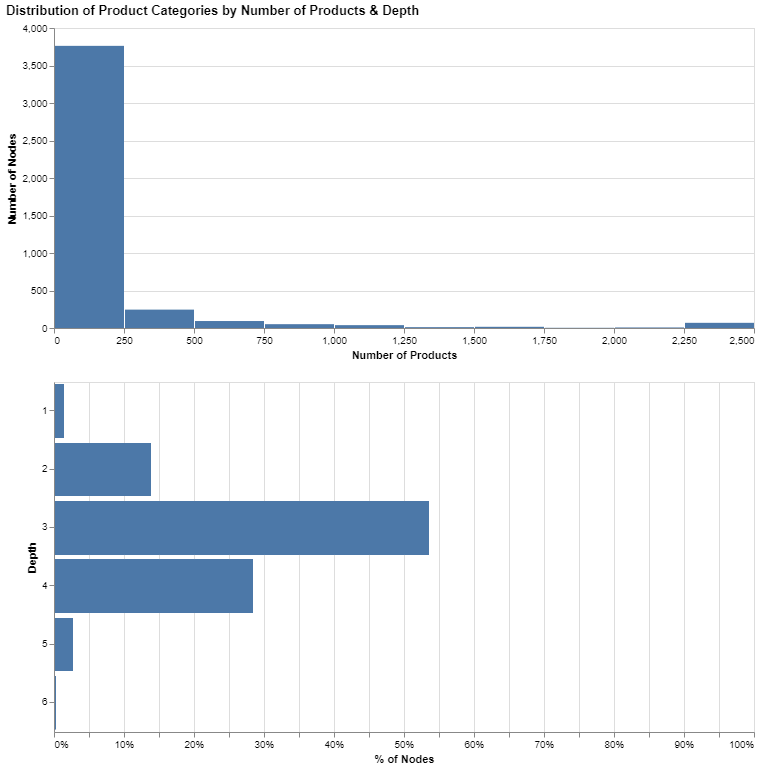

In [65]:
#Selection for top chart
brush = alt.selection_interval(encodings=['x'],empty='all')

#Product categories by number of products
top = alt.Chart(books_df[1:]).mark_bar().encode(
        alt.X("productCount:Q",
          bin=alt.BinParams(extent = [0,2500], step = 250),
          scale=alt.Scale(domain=(0, 2500)),
          axis=alt.Axis(title="Number of Products")),
        alt.Y('count()',
          axis=alt.Axis(title = "Number of Nodes"))
    ).properties(width = 700
    ).add_selection(brush)

#Product categories by depth
bottom = alt.Chart(books_df[1:]).mark_bar().encode(
        alt.X("percent_of_total:Q",
             scale=alt.Scale(domain=(0,1)),
             axis=alt.Axis(title = "% of Nodes", format = '.0%')),
        alt.Y('Depth:O',
              scale=alt.Scale(domain=(1,2,3,4,5,6)))
    ).properties(width = 700, height = 350
    ).transform_filter(brush
    ).transform_joinaggregate(
        total_count='count(Depth)'
    ).transform_joinaggregate(
        depth_count='count(Depth)',
        groupby=['Depth']
    ).transform_calculate(
        percent_of_total = "datum.depth_count / datum.total_count")


alt.vconcat(top,
            bottom, 
            data=books_df, 
            title = "Distribution of Product Categories by Number of Products & Depth",
            resolve = alt.Resolve(scale=alt.LegendResolveMap(color=alt.ResolveMode('independent')))).display()